# Logistic Regression

## Import Data

In [1]:
import numpy as np
import pandas as pd

train_df = pd.read_parquet("../data/train_lin_preprocessed.parquet")
print(train_df.shape)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']

test_df = pd.read_parquet("../data/test_lin_preprocessed.parquet")
print(test_df.shape)

X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

(1076248, 80)
(269062, 80)


## Analyse Collinearity

### Drop Uncorrelated Features

In [2]:
import pandas as pd

def drop_low_corr_features(df: pd.DataFrame, threshold: float):
    corr_with_target = df.corr()['target'].abs()

    # 2) Find features below the threshold (excluding the target itself)
    to_drop = corr_with_target[corr_with_target < threshold].index.tolist()

    # 3) Drop them from the original df
    df_reduced = df.drop(columns=to_drop)

    return df_reduced

red_train_df = drop_low_corr_features(train_df.copy(), 0.01)
red_train_df.shape

(1076248, 65)

### Correlation Matrix

In [3]:
import networkx as nx
from itertools import combinations
import pandas as pd

def collinearity_blocks(df: pd.DataFrame, cols: list[str],threshold):

    # ── NEW: ensure target isn’t in the feature list ───────────────────────
    cols = [c for c in cols if c != 'target']
    cols_to_drop = []

    # 1) absolute correlation matrix for the chosen columns
    corr = df[cols].corr().abs()

    # 2) build a graph linking any pair above the threshold
    G = nx.Graph()
    G.add_nodes_from(cols)
    for i, j in combinations(cols, 2):
        if corr.loc[i, j] > threshold:
            G.add_edge(i, j)

    # 3) connected components = collinear blocks
    groups = list(nx.connected_components(G))

    # 4) optional pretty-print
    for idx, block in enumerate(groups, 1):
        if len(block) != 1:
            temp_corr = 0
            temp_feat = None
            block_cols_to_drop = []
            print(f"\nBlock {idx}:")
            for feat in sorted(block):
                r = df[feat].corr(df['target'])
                print(f"  • {feat:20s} corr with target = {r:.3f}")
                block_cols_to_drop.append(feat)
                r_abs = np.abs(r)

                if r_abs > temp_corr:
                    temp_corr = r_abs
                    temp_feat = feat
            
            block_cols_to_drop.remove(temp_feat)
            cols_to_drop += block_cols_to_drop

    return cols_to_drop

In [4]:
collinearity_blocks(red_train_df,red_train_df.columns,0.8)


Block 2:
  • installment          corr with target = 0.051
  • loan_amnt            corr with target = 0.065
  • total_amnt_due       corr with target = 0.117

Block 3:
  • int_rate             corr with target = 0.259
  • sub_grade_encoded    corr with target = 0.268
  • term_x_sub_grade     corr with target = 0.271

Block 8:
  • num_op_rev_tl        corr with target = 0.034
  • num_sats             corr with target = 0.026
  • open_acc             corr with target = 0.028

Block 10:
  • revol_bal            corr with target = -0.021
  • total_rev_hi_lim     corr with target = -0.051

Block 13:
  • avg_cur_bal          corr with target = -0.071
  • tot_cur_bal          corr with target = -0.068
  • tot_hi_cred_lim      corr with target = -0.075

Block 15:
  • bc_open_to_buy       corr with target = -0.077
  • total_bc_limit       corr with target = -0.070

Block 16:
  • bc_util              corr with target = 0.068
  • percent_bc_gt_75     corr with target = 0.069

Block 24:
  • num_

['installment',
 'loan_amnt',
 'int_rate',
 'sub_grade_encoded',
 'num_sats',
 'open_acc',
 'revol_bal',
 'avg_cur_bal',
 'tot_cur_bal',
 'total_bc_limit',
 'bc_util',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_rev_tl_bal_gt_0',
 'dti_clipped',
 'term_60.0',
 'application_type_Joint App',
 'home_ownership_grouped_RENT']

In [5]:
# Let's use the above list to help us cherry pick which columns to drop.
# We will # out the columns of the list we want to retain, and include adjacent to them the column we will drop in its place.

high_corr_cols_to_drop = ['installment',
 'loan_amnt', # Made redundant by 'total_amnt_due'
 'int_rate', # It seems strange to drop interest rate, however it appears to be nearly entirely determined by subgrade, so let's keep term_x_sub_grade
 'sub_grade_encoded', # as it is the most predictive and likely the most informative since it also includes the term. This may allow us to drop both of the term columns later on.
 'num_sats',
 'open_acc',
 'revol_bal',
 'avg_cur_bal',
 'tot_cur_bal',
 'total_bc_limit',
 'percent_bc_gt_75',
#  'bc_util', Seems more informative than 'percent_bc_gt_75'.
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_rev_tl_bal_gt_0',
 'dti_clipped',
 'term_36.0',
#  'term_60.0', Personal choice, as a term of 60 is more common.
 'application_type_Joint App',
 'home_ownership_grouped_RENT']

red_train_df = red_train_df.drop(columns=high_corr_cols_to_drop)
red_train_df.shape

(1076248, 47)

We have already reduced from 79 features to 46 just by removing features with low correlation to the target and features with high collinearity. Let's further look at collinearity to see if we can reduce the number of features any more before moving on to analysing VIFs.

In [6]:
collinearity_blocks(red_train_df,red_train_df.columns,0.7)


Block 7:
  • bc_util              corr with target = 0.068
  • revol_util           corr with target = 0.059

Block 10:
  • acc_open_past_24mths corr with target = 0.098
  • num_tl_op_past_12m   corr with target = 0.084

Block 19:
  • num_actv_rev_tl      corr with target = 0.070
  • num_op_rev_tl        corr with target = 0.034

Block 28:
  • acct_null_flag       corr with target = -0.027
  • zero_il_accts_flag   corr with target = -0.018
  • zero_recent_bc_flag  corr with target = -0.022

Block 30:
  • term_60.0            corr with target = 0.176
  • term_x_sub_grade     corr with target = 0.271


['revol_util',
 'num_tl_op_past_12m',
 'num_op_rev_tl',
 'zero_il_accts_flag',
 'zero_recent_bc_flag',
 'term_60.0']

In [7]:
# Looking at these and comparing with the data dictionary, we know that each block of features are fairly similar in definition and likely don't add much.
# Therefore we can drop these features as before. Note that, as asserted previously, we can now drop both term columns.
# I also ran these through the VIF function below and they had higher values than most other features.

med_corr_cols_to_drop = ['revol_util',
 'num_tl_op_past_12m',
 'num_op_rev_tl',
 'zero_il_accts_flag',
 'zero_recent_bc_flag',
 'term_60.0']

red_train_df = red_train_df.drop(columns=med_corr_cols_to_drop)
red_train_df.shape

(1076248, 41)

### VIF

VIF will be very computationally expensive unless we reduce the number of features by looking at both correlation with the target and their multicollinearity with other features.

In [8]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(df):
    X = sm.add_constant(red_train_df)
    vif_data = pd.DataFrame({
        "feature": red_train_df.columns,
        "VIF": [variance_inflation_factor(X, i+1)  # +1 to skip the constant
                for i in range(len(red_train_df.columns))]
    })
    return vif_data.sort_values(by="VIF", ascending=False)

In [9]:
# print(vif(red_train_df))

In [10]:
# Clearly we need to drop one of the verification status columns. Let's drop not verified.

red_train_df = red_train_df.drop(columns=['verification_status_Not Verified'])

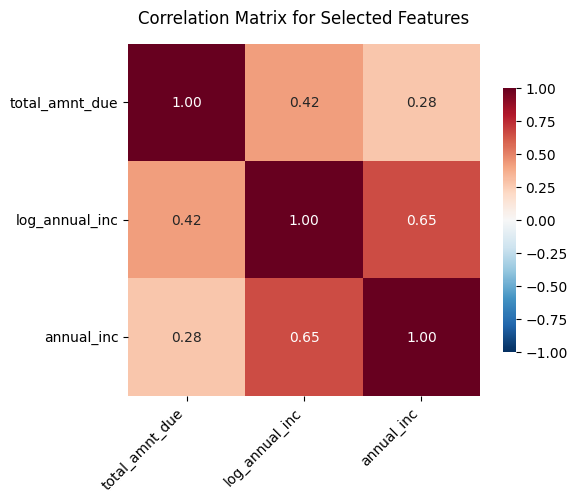

In [11]:
# Now let's look at the correlations among 'loan_amnt', 'loan_to_income_clipped', 'log_annual_inc' and 'annual_inc'.

import seaborn as sns
import matplotlib.pyplot as plt

# Select only the four columns
cols = ['total_amnt_due', 'log_annual_inc', 'annual_inc']
subset = red_train_df[cols]

# Compute and display the correlation matrix
corr_matrix = subset.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,        # show the correlation coefficients
    fmt=".2f",         # two decimal places
    cmap="RdBu_r",     # diverging palette
    vmin=-1, vmax=1,   # fixed colour scale
    xticklabels=cols,
    yticklabels=cols,
    square=True,
    cbar_kws={"shrink": .75}
)

# Tidy up the labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix for Selected Features", pad=15)
plt.tight_layout()
plt.show()


In [13]:
# Let's drop 'loan_amnt' as 'loan_to_income_clipped' is far more predictive, and we're happy measuring the size of a loan by the multiple of an applicant's income.

# red_train_df = red_train_df.drop(columns=['loan_amnt'])

In [14]:
print(vif(red_train_df))

                                feature       VIF
26                       log_annual_inc  3.053704
34           purpose_debt_consolidation  2.780109
33                  purpose_credit_card  2.519128
6                             total_acc  2.518805
9                        bc_open_to_buy  2.477802
25                       total_amnt_due  2.445333
22                      tot_hi_cred_lim  2.282524
19                            num_bc_tl  2.275605
13                mo_sin_rcnt_rev_tl_op  2.199745
7                      total_rev_hi_lim  2.183573
23                             fico_avg  2.110537
10                              bc_util  1.998364
29                     term_x_sub_grade  1.930523
8                  acc_open_past_24mths  1.849038
14                       mo_sin_rcnt_tl  1.839499
24                    total_dti_clipped  1.834518
21                 pub_rec_bankruptcies  1.828364
2                            annual_inc  1.806691
5                               pub_rec  1.759940


These all look very healthy now.

In [15]:
print(red_train_df.shape)

(1076248, 40)


### PCA

In [16]:
from sklearn.decomposition import PCA

def pca_summary(df: pd.DataFrame, threshold: float = 0.95):

    X = df.copy()
    if 'target' in X.columns:
        X = X.drop(columns='target')
    
    pca_full = PCA()
    pca_full.fit(X)
    evr = pca_full.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    
    plt.figure(figsize=(8,5))
    plt.plot(range(1, min(10, len(evr))+1), evr[:10], marker='o')
    plt.xticks(range(1, min(10, len(evr))+1))
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Variance Explained by the First 10 Principal Components")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(7,4))
    plt.plot(np.arange(1, len(cum_evr)+1), cum_evr, marker='o')
    plt.axhline(threshold, color='red', linestyle='--', 
                label=f"{int(threshold*100)}% threshold")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Variance Explained by PCA")
    plt.xticks(np.arange(0, len(cum_evr)+1, max(1, len(cum_evr)//10)))
    plt.ylim(0, 1.02)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    n_components = int(np.argmax(cum_evr >= threshold) + 1)
    
    loadings = pd.DataFrame(
        pca_full.components_,
        index=[f"PC{i+1}" for i in range(len(evr))],
        columns=X.columns
    )
    print(f"\nComponents explaining >5% of the variance:\n")
    for i, var_ratio in enumerate(evr):
        if var_ratio > 0.05:
            pc_label = f"PC{i+1}"
            top_feats = (
                loadings.loc[pc_label]
                .abs()
                .sort_values(ascending=False)
                .head(5)
            )
            print(f"{pc_label} ({var_ratio:.2%} of variance):")
            for feat, loading in top_feats.items():
                print(f"  • {feat:25s} loading = {loading:.3f}")
            print()
    
    return n_components


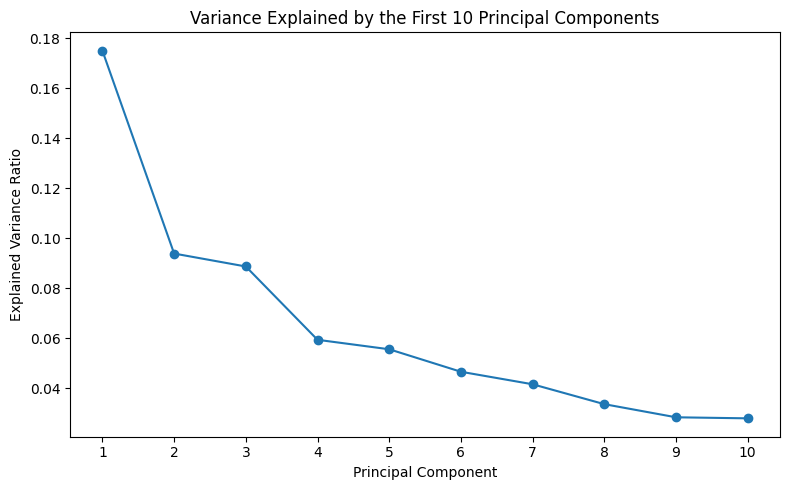

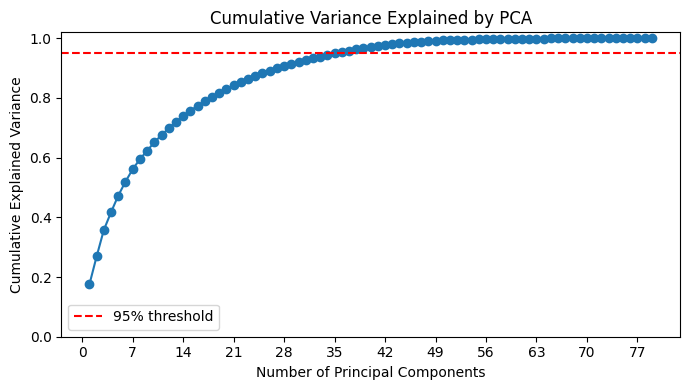


Components explaining >5% of the variance:

PC1 (17.50% of variance):
  • open_acc                  loading = 0.259
  • num_sats                  loading = 0.257
  • num_op_rev_tl             loading = 0.249
  • num_bc_sats               loading = 0.232
  • total_acc                 loading = 0.231

PC2 (9.39% of variance):
  • avg_cur_bal               loading = 0.292
  • tot_hi_cred_lim           loading = 0.264
  • tot_cur_bal               loading = 0.262
  • log_annual_inc            loading = 0.217
  • mo_sin_rcnt_rev_tl_op     loading = 0.189

PC3 (8.88% of variance):
  • bc_util                   loading = 0.319
  • sub_grade_encoded         loading = 0.300
  • revol_util                loading = 0.298
  • int_rate                  loading = 0.296
  • percent_bc_gt_75          loading = 0.295

PC4 (5.94% of variance):
  • num_tl_op_past_12m        loading = 0.276
  • mo_sin_rcnt_tl            loading = 0.262
  • acc_open_past_24mths      loading = 0.245
  • bc_util            

36

In [17]:
pca_summary(train_df)

It seems that even with PCA, we would need a lot of features to explain most of the variance. Setting the threshold to 90% requires 28 principal components.

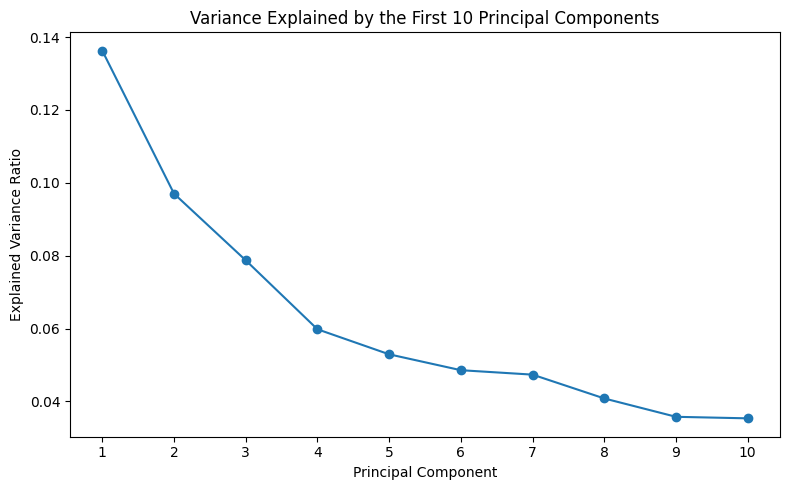

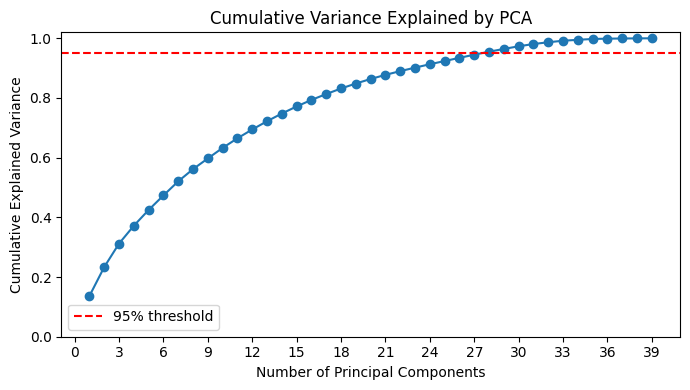


Components explaining >5% of the variance:

PC1 (13.62% of variance):
  • total_acc                 loading = 0.342
  • total_rev_hi_lim          loading = 0.315
  • num_bc_tl                 loading = 0.315
  • tot_hi_cred_lim           loading = 0.314
  • log_annual_inc            loading = 0.299

PC2 (9.70% of variance):
  • mo_sin_rcnt_rev_tl_op     loading = 0.377
  • mo_sin_rcnt_tl            loading = 0.337
  • acc_open_past_24mths      loading = 0.335
  • mths_since_recent_bc      loading = 0.317
  • fico_avg                  loading = 0.274

PC3 (7.87% of variance):
  • bc_util                   loading = 0.440
  • fico_avg                  loading = 0.385
  • bc_open_to_buy            loading = 0.302
  • pct_tl_nvr_dlq            loading = 0.263
  • term_x_sub_grade          loading = 0.256

PC4 (5.98% of variance):
  • total_dti_clipped         loading = 0.492
  • pub_rec                   loading = 0.341
  • pub_rec_bankruptcies      loading = 0.319
  • pct_tl_nvr_dlq     

28

In [18]:
pca_summary(red_train_df)

## Modelling without SMOTE

### Correlation Matrix & VIF Chosen Features

In [19]:
feats = red_train_df.drop(columns=['target']).columns

Using Logistic Regression in it's normal form was taking far too long, so we will use SGDClassifier instead.

In [20]:
alpha_vals = np.logspace(-2, 0, 3)

params = [
    # L1 regularisation
    {
        'penalty': ['l1'],
        'alpha':   alpha_vals,
    },
    # L2 regularisation
    {
        'penalty': ['l2'],
        'alpha':   alpha_vals,
    },
    # Elastic-net regularisation
    {
        'penalty':  ['elasticnet'],
        'alpha':    alpha_vals,
        'l1_ratio': [0.0, 0.5, 1.0],   # 0=L2, 1=L1, .5=mix
    },
]

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

def cv_sgd_log_reg(train_df: pd.DataFrame, test_df: pd.DataFrame, feats, param_grid, scoring_method: str):
    # Prepare data
    X = train_df[feats]
    y = train_df['target']

    # Initialise SGD‐based “logistic regression” with early stopping
    sgd = SGDClassifier(
        loss='log_loss',               # logistic loss
        class_weight='balanced',  # handle 80/20 imbalance
        early_stopping=True,      # stop when validation score plateaus
        validation_fraction=0.1,  # 10% of train → internal val set
        n_iter_no_change=5,       # epochs with no improvement → stop
        tol=1e-3,                 # minimum change to count as “improvement”
        max_iter=20,            # hard cap on epochs
        random_state=42,
        verbose=1                 # per-epoch logs
    )

    # StratifiedKFold preserves the 80/20 target split
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=sgd,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring_method,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)

    print("Best CV ROC AUC:", grid.best_score_)
    print("Best parameters:", grid.best_params_)

    # Evaluate on test set
    best_model = grid.best_estimator_
    X_test_chosen_feats = test_df[feats]
    y_test = test_df['target']  # or 'defaulted', whichever you use

    # Note: SGDClassifier supports predict_proba after loss='log'
    y_pred  = best_model.predict(X_test_chosen_feats)
    y_proba = best_model.predict_proba(X_test_chosen_feats)[:, 1]

    print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    print("PR AUC:", auc(recall,precision))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


In [22]:
# cv_sgd_log_reg(train_df,test_df,feats,params,"roc_auc")

In [23]:
# cv_sgd_log_reg(train_df,test_dffeats,params,"recall")

### All Features

In [24]:
# cv_sgd_log_reg(train_df,test_df,train_df.drop(columns=['target']).columns,params,"roc_auc")

In [25]:
# cv_sgd_log_reg(train_df,test_df,train_df.drop(columns=['target']).columns,params,"recall")

### PCA

In [26]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('pca', PCA(random_state=42)),    # we’ll tune n_components
    ('clf', SGDClassifier(
        loss='log_loss',
        class_weight='balanced',
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-3,
        max_iter=20,
        random_state=42
    ))
])

PCA_param_grid = [{
    'pca__n_components': [36],                 # the amount required for the 95th percentile of variance explained for train_df
    'clf__alpha':         alpha_vals,              # regularisation strengths
    'clf__penalty':       ['l2', 'elasticnet'],    # penalty types
    'clf__l1_ratio':      [0.0, 0.5, 1.0],         # only used for elasticnet
}]

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, PCA_param_grid, scoring='roc_auc', cv=cv,
                    n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV ROC AUC :", grid.best_score_)

# Final eval on test
y_proba = grid.predict_proba(X_test)[:,1]
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, grid.predict(X_test)))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.0, 'clf__penalty': 'l2', 'pca__n_components': 36}
CV ROC AUC : 0.7153931515984899
Test ROC AUC: 0.7158903251103375
              precision    recall  f1-score   support

           0       0.88      0.67      0.76    215350
           1       0.33      0.65      0.43     53712

    accuracy                           0.66    269062
   macro avg       0.61      0.66      0.60    269062
weighted avg       0.77      0.66      0.70    269062



As we can see, the PCA transformed logistic regression performs no better.

## Modelling with SMOTE

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

res_train_df = X_res.copy()
res_train_df['target'] = y_res

print(res_train_df.shape)
print(res_train_df['target'].mean())

(1722802, 80)
0.5


In [28]:
cv_sgd_log_reg(res_train_df,test_df,feats,params,"roc_auc")

Fitting 4 folds for each of 15 candidates, totalling 60 fits
-- Epoch 1
Norm: 0.67, NNZs: 39, Bias: -0.298853, T: 1550521, Avg. loss: 0.617118
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 0.67, NNZs: 39, Bias: -0.295415, T: 3101042, Avg. loss: 0.615289
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.67, NNZs: 39, Bias: -0.294964, T: 4651563, Avg. loss: 0.615254
Total training time: 1.32 seconds.
-- Epoch 4
Norm: 0.66, NNZs: 39, Bias: -0.295424, T: 6202084, Avg. loss: 0.615236
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 0.67, NNZs: 39, Bias: -0.295914, T: 7752605, Avg. loss: 0.615235
Total training time: 2.24 seconds.
-- Epoch 6
Norm: 0.67, NNZs: 39, Bias: -0.296856, T: 9303126, Avg. loss: 0.615228
Total training time: 2.68 seconds.
Convergence after 6 epochs took 2.70 seconds
Best CV ROC AUC: 0.7211868415194397
Best parameters: {'alpha': 0.01, 'penalty': 'l2'}
Test ROC AUC: 0.7128632663510482
PR AUC: 0.3786981016123217
Confusion Matrix:
[[144437  70913]
 [ 19476  3